# Abstract

Add scale verification...

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from functools import partial
from itertools import cycle
from time import perf_counter
from tabulate import tabulate

from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.evaluate import compute_map_and_print
from asmk import io_helpers, ASMKMethod, functional, hamming
from examples.demo_how import build_ivf, query_ivf

In [2]:
def get_packed_residuals(vecs, centroids, binary=True):
    residuals = vecs - centroids
    
    if binary:
        return hamming.binarize_and_pack_2D(residuals)
    else:
        return functional.normalize_vec_l2(residuals)
    
def generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2):
    # 1 -> 2
    m = np.tile(np.eye(3), [coordx1.size, 1, 1])
    s = scales2 / scales1
    
    m[:, 0, 2] = -1 * coordx1 * s + coordx2
    m[:, 1, 2] = -1 * coordy1 * s + coordy2
    m[:, 0, 0] = m[:, 1, 1] = s
    
    return m


def compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2):
    pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
    pts2 = np.vstack([coordx2, coordy2, np.ones_like(coordx2)])
    
    # [number of hypotheses, number of correspondences]
    return np.linalg.norm((hypotheses @ pts1) - pts2, axis=1)


def verify_single_model(errors, corrs, inlier_threshold=32):
    n = corrs.shape[0]
    mask = np.zeros([n], dtype=bool)
    taken = set()

    i = 0
    actual_y, best_index = None, None
    best_error = None
    while i < n:
        actual_y = corrs[i, 1]
        
        best_error = np.inf
        best_index = -1
        while i < n and actual_y == corrs[i, 1]:
            if errors[i] < best_error and corrs[i, 0] not in taken:
                best_error = errors[i]
                best_index = i
            i += 1
        
        if best_error <= inlier_threshold:
            mask[best_index] = True
            taken.add(corrs[best_index, 0])
    
    return mask


def verify_models(errors, corrs, inlier_threshold=32):
    return np.apply_along_axis(
        partial(verify_single_model, corrs=corrs, inlier_threshold=inlier_threshold),
        axis=1,
        arr=errors,
    )


def affine_local_optimization(A, coordx1, coordy1, coordx2, coordy2):
    size = coordx1.size
    
    if size < 3:
        return A
    
    weight = 2 * np.pi if size < 11 else 0
    r2h = 50.0  # half of squared circle radius is integrated over
    
    mx1, my1 = coordx1.mean(), coordy1.mean()
    mx2, my2 = coordx2.mean(), coordy2.mean()
    
    dx1, dy1 = (coordx1 - mx1), (coordy1 - my1)
    dx2, dy2 = (coordx2 - mx2), (coordy2 - my2)
    
    # Compute AtA, AtB1, AtB2
    AtA = [0.0, 0.0, 0.0]
    AtB1 = [0.0, 0.0]
    AtB2 = [0.0, 0.0]
    
    AtA[0] = ((1 + weight) * dx1 * dx1 + weight * r2h).sum()
    AtA[1] = ((1 + weight) * dx1 * dy1).sum()
    AtA[2] = ((1 + weight) * dy1 * dy1 + weight * r2h).sum()
    
    AtB1[0] = ((1 + weight) * dx1 * dx2 + weight * A[0, 0] * r2h).sum()
    AtB1[1] = ((1 + weight) * dy1 * dx2 + weight * A[0, 1] * r2h).sum()
    
    AtB2[0] = ((1 + weight) * dx1 * dy2 + weight * A[1, 0] * r2h).sum()
    AtB2[1] = ((1 + weight) * dy1 * dy2 + weight * A[1, 1] * r2h).sum()
    
    # Final affine transformation
    detAtA = AtA[0] * AtA[2] - AtA[1] * AtA[1]
    if detAtA == 0:
        raise ValueError('Determinant equals to zero.')
        
    norm = 1 / detAtA
    H0 = (AtA[2] * AtB1[0] - AtA[1] * AtB1[1]) * norm
    H1 = (-AtA[1] * AtB1[0] + AtA[0] * AtB1[1]) * norm
    H2 = mx2 - mx1 * H0 - my1 * H1
    H3 = (AtA[2] * AtB2[0] - AtA[1] * AtB2[1]) * norm
    H4 = (-AtA[1] * AtB2[0] + AtA[0] * AtB2[1]) * norm
    H5 = my2 - mx1 * H3 - my1 * H4
    
    H = np.array([
        [H0, H1, H2],
        [H3, H4, H5],
        [0, 0, 1],
    ])
    
    return H


def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                    
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np

In [3]:
PARAMETERS_PATH = 'eccv20_how_r50-_1000'
DATASET = 'roxford5k'
EVAL_FEATURES = 'how_r50-_1000'

# Global variables
package_root = Path('.').resolve().parent / 'asmk'
parameters_path = package_root / "examples" / ("params/%s.yml" % PARAMETERS_PATH)
params = io_helpers.load_params(parameters_path)

globals = {}
globals["root_path"] = (package_root / params['demo_how']['data_folder'])
exp_name = Path(parameters_path).name[:-len(".yml")]
globals["exp_path"] = (package_root / params['demo_how']['exp_folder']) / exp_name

# Setup logging
logger = io_helpers.init_logger(None)
logger.info("All variables and logger set up")

# Run demo
asmk = ASMKMethod.initialize_untrained(params)
logger.info("Created uninitialized ASMK")
asmk = asmk.train_codebook(cache_path=f"{globals['exp_path']}/codebook.pkl")
logger.info("Trained ASMK")

desc = io_helpers.load_pickle(f"{globals['root_path']}/features/{DATASET}_{EVAL_FEATURES}.pkl")
gnd = configdataset(DATASET, f"{globals['root_path']}/test/")

asmk_dataset = build_ivf(asmk, DATASET, desc, globals, logger)

ASMK INFO: All variables and logger set up
ASMK INFO: Created uninitialized ASMK
ASMK INFO: Trained ASMK
ASMK INFO: Loaded indexed ivf


In [4]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])


def kernel_similarity(v1, v2):
    _, sim = asmk_dataset.kernel.similarity(v1, v2[np.newaxis], np.array([0]), alpha=1, similarity_threshold=-np.inf)
    return sim

tohle ** 2 nasobit determinantem
nebo
tohle nasobit odmocninou z determinantu

In [5]:
t0 = perf_counter()

# Get centroid ids, then centroids and then residual packs
qvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['qvecs'], multiple_assignment=1)[1].ravel()
# dbvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['vecs'], multiple_assignment=1)[1].ravel()
dbvecs_centroid_ids = np.load('desc_vecs-quantized-dbvecs_centroid_ids.npy')

# ---
q_centroids = asmk_dataset.codebook.centroids[qvecs_centroid_ids]
db_centroids = asmk_dataset.codebook.centroids[dbvecs_centroid_ids]

q_residual_packs = get_packed_residuals(desc['qvecs'], q_centroids, binary=asmk_dataset.kernel.binary)
db_residual_packs = get_packed_residuals(desc['vecs'], db_centroids, binary=asmk_dataset.kernel.binary)

t1 = perf_counter()

(t1 - t0)

7.167025250004372

In [6]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'

---

In [51]:
qi = 0
dbi = 296
# dbi = 69

query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
result_img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][dbi]}.jpg')
qbbx = gnd['gnd'][qi]['bbx']
    
# Query data
ql = np.searchsorted(desc['qimids'], qi, 'left')
qr = np.searchsorted(desc['qimids'], qi, 'right')
    
q_vecs = desc['qvecs'][ql:qr]
q_centroid_ids = qvecs_centroid_ids[ql:qr]
q_coordx = desc['qcoordx'][ql:qr]
q_coordy = desc['qcoordy'][ql:qr]
q_scales = desc['qscales'][ql:qr]
q_residuals = q_residual_packs[ql:qr]
    
# Database data
dbl = np.searchsorted(desc['imids'], dbi, 'left')
dbr = np.searchsorted(desc['imids'], dbi, 'right')
        
db_vecs = desc['vecs'][dbl:dbr]
db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
db_coordx = desc['coordx'][dbl:dbr]
db_coordy = desc['coordy'][dbl:dbr]
db_scales = desc['scales'][dbl:dbr]
db_residuals = db_residual_packs[dbl:dbr]
    
########################
# SPATIAL VERIFICATION #
    
# Generate correspondences
corrs, similarities = get_tentative_correspondencies(
    q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
)
_similarities = similarities * (similarities > 0)
print('#corrs:', corrs.shape)
        
# Pick corresponding data
scales1 = scales[q_scales[corrs[:, 0]]]
coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

scales2 = scales[db_scales[corrs[:, 1]]]
coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
# Generate hypotheses
hypotheses = generate_hypotheses(
    coordx1,
    coordy1,
    scales1,
    coordx2,
    coordy2,
    scales2,
)
        
# Compute errors and verify models
errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
verifications = verify_models(errors, corrs)
        
# Local optimization of the best model
scores = (verifications * _similarities[np.newaxis]).sum(axis=1)
best_index = scores.argmax()
    
A = hypotheses[best_index]
score = scores[best_index]
mask = verifications[best_index]
origin = best_index
        
# Final output
print(f'Found {mask.sum()} inliers with score {score}')

#corrs: (734, 2)
Found 71 inliers with score 25.140625


In [52]:
det = np.linalg.det(A)
det

1.0

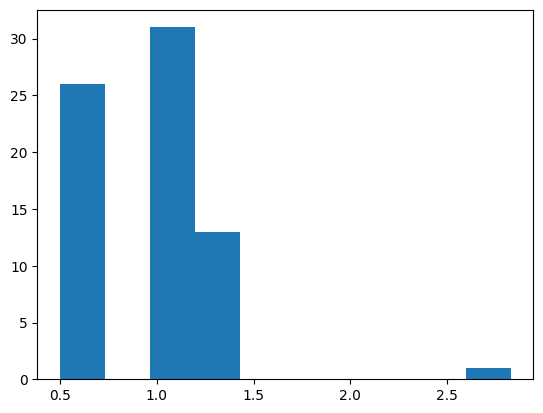

In [55]:
plt.hist(scales1[mask] * np.sqrt(det) / scales2[mask])
plt.show()

In [10]:
qi = 0

for dbi in gnd['gnd'][qi]['easy']:
    query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
    result_img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][dbi]}.jpg')
    qbbx = gnd['gnd'][qi]['bbx']

    # Query data
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')

    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]

    # Database data
    dbl = np.searchsorted(desc['imids'], dbi, 'left')
    dbr = np.searchsorted(desc['imids'], dbi, 'right')

    db_vecs = desc['vecs'][dbl:dbr]
    db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
    db_coordx = desc['coordx'][dbl:dbr]
    db_coordy = desc['coordy'][dbl:dbr]
    db_scales = desc['scales'][dbl:dbr]
    db_residuals = db_residual_packs[dbl:dbr]

    ########################
    # SPATIAL VERIFICATION #

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    scores = (verifications * _similarities[np.newaxis]).sum(axis=1)
    best_index = scores.argmax()

    A = hypotheses[best_index]
    score = scores[best_index]
    mask = verifications[best_index]
    origin = best_index

    # Final output
    print(f'dbi={dbi} \t supp={mask.sum()} \t score={score} \t det={np.linalg.det(A)}')

dbi=30 	 supp=18 	 score=4.078125 	 det=0.500151045615776
dbi=69 	 supp=61 	 score=21.75 	 det=1.0
dbi=296 	 supp=71 	 score=25.140625 	 det=1.0
dbi=324 	 supp=51 	 score=17.234375 	 det=0.500151045615776
dbi=581 	 supp=51 	 score=16.875 	 det=1.0
dbi=623 	 supp=29 	 score=8.5 	 det=0.49984899999999993
dbi=685 	 supp=9 	 score=2.390625 	 det=0.062323321643136226
dbi=691 	 supp=19 	 score=5.859375 	 det=1.0
dbi=736 	 supp=44 	 score=12.609375 	 det=0.49984899999999993
dbi=801 	 supp=29 	 score=8.5 	 det=0.49984899999999993
dbi=953 	 supp=17 	 score=4.515625 	 det=0.49984899999999993
dbi=1125 	 supp=50 	 score=15.0625 	 det=0.500151045615776
dbi=1232 	 supp=71 	 score=23.609375 	 det=1.0
dbi=1318 	 supp=45 	 score=15.34375 	 det=1.0
dbi=1392 	 supp=35 	 score=13.515625 	 det=1.0
dbi=1520 	 supp=8 	 score=2.828125 	 det=4.0
dbi=1581 	 supp=14 	 score=3.75 	 det=0.49984899999999993
dbi=1619 	 supp=26 	 score=6.8125 	 det=0.500151045615776
dbi=1643 	 supp=7 	 score=1.390625 	 det=1.0
dbi=16

---

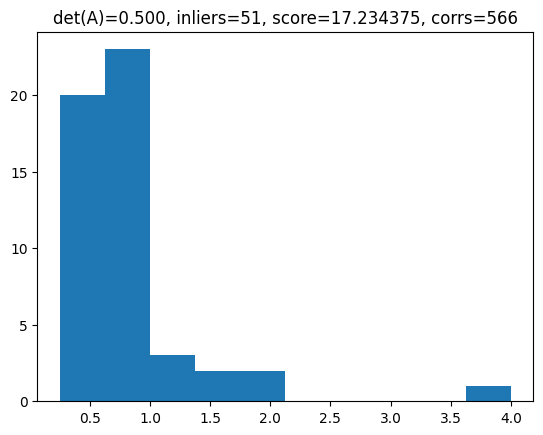

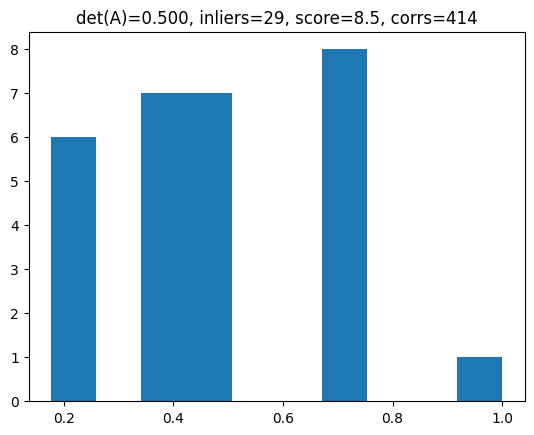

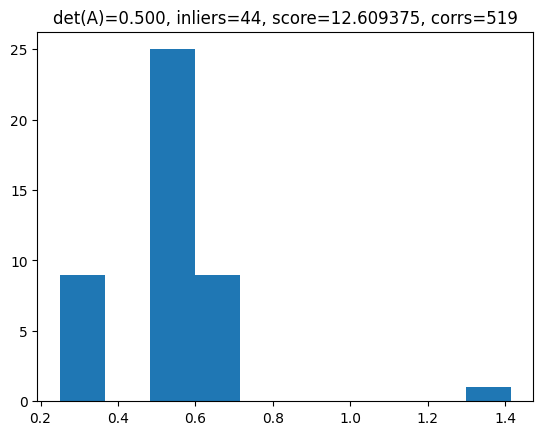

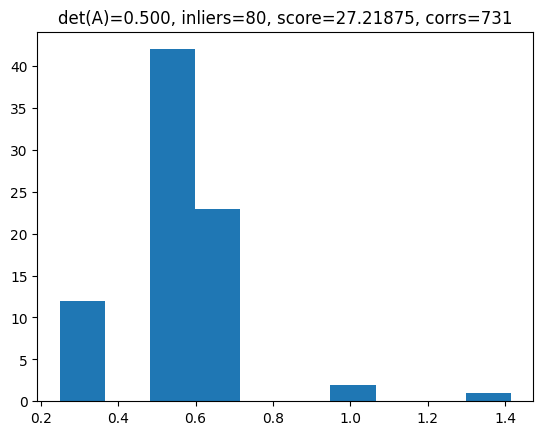

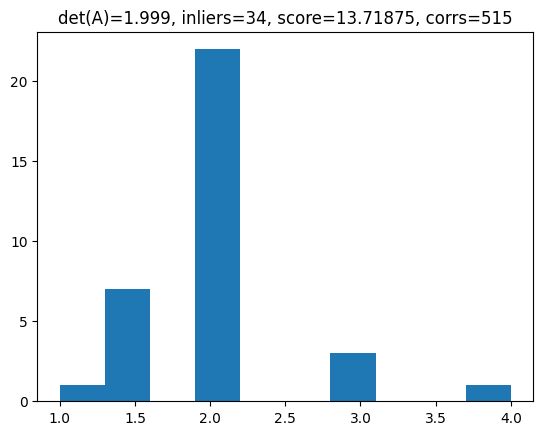

In [56]:
qi = 0

for dbi in [324, 623, 736, 2293, 4960]:
    query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
    result_img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][dbi]}.jpg')
    qbbx = gnd['gnd'][qi]['bbx']

    # Query data
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')

    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]

    # Database data
    dbl = np.searchsorted(desc['imids'], dbi, 'left')
    dbr = np.searchsorted(desc['imids'], dbi, 'right')

    db_vecs = desc['vecs'][dbl:dbr]
    db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
    db_coordx = desc['coordx'][dbl:dbr]
    db_coordy = desc['coordy'][dbl:dbr]
    db_scales = desc['scales'][dbl:dbr]
    db_residuals = db_residual_packs[dbl:dbr]

    ########################
    # SPATIAL VERIFICATION #

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    scores = (verifications * _similarities[np.newaxis]).sum(axis=1)
    best_index = scores.argmax()

    A = hypotheses[best_index]
    score = scores[best_index]
    mask = verifications[best_index]
    origin = best_index

    # Final output
    det = np.linalg.det(A)

    plt.hist(scales1[mask] * np.sqrt(det) / scales2[mask])
    plt.title(f'det(A)={det:.3f}, inliers={mask.sum()}, score={score}, corrs={corrs.shape[0]}')
    plt.show()

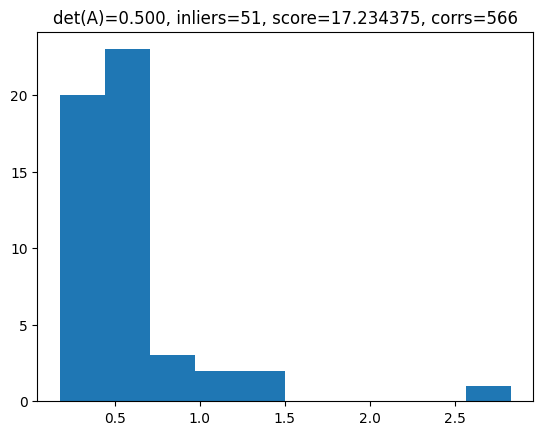

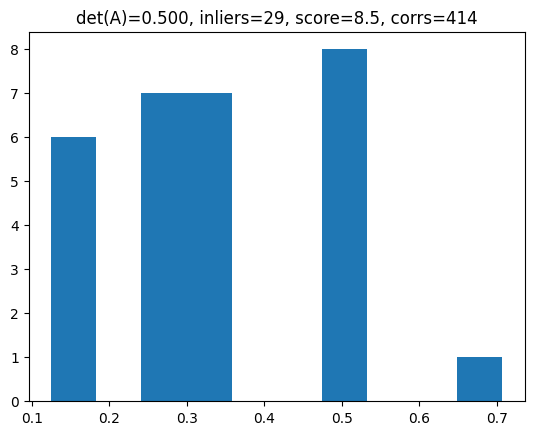

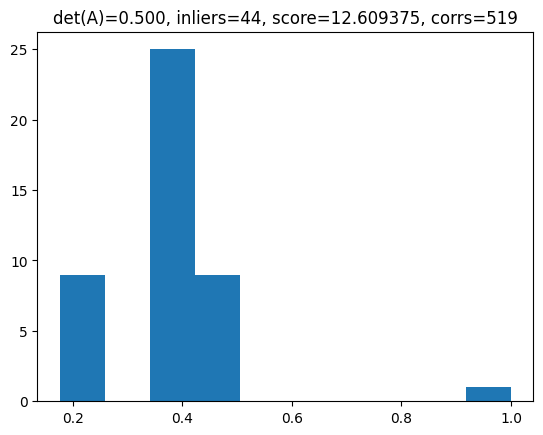

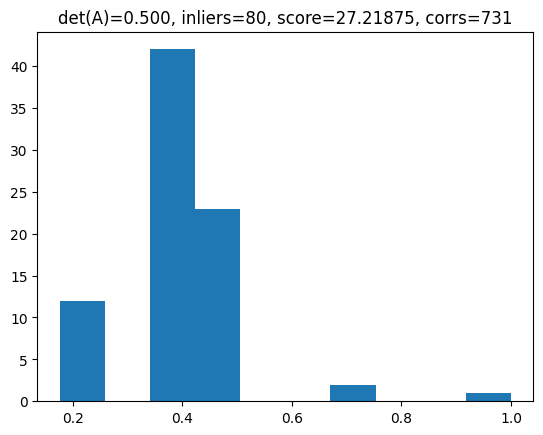

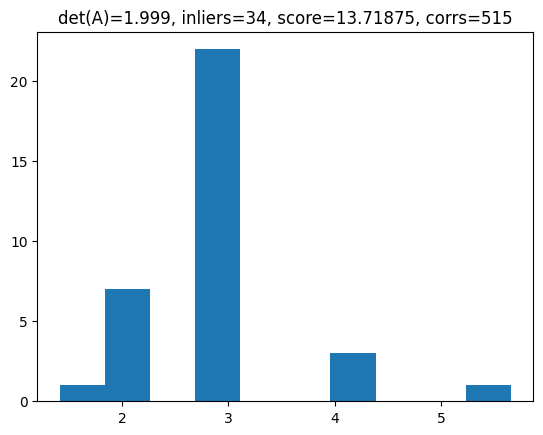

In [12]:
qi = 0

for dbi in [324, 623, 736, 2293, 4960]:
    query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
    result_img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][dbi]}.jpg')
    qbbx = gnd['gnd'][qi]['bbx']

    # Query data
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')

    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]

    # Database data
    dbl = np.searchsorted(desc['imids'], dbi, 'left')
    dbr = np.searchsorted(desc['imids'], dbi, 'right')

    db_vecs = desc['vecs'][dbl:dbr]
    db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
    db_coordx = desc['coordx'][dbl:dbr]
    db_coordy = desc['coordy'][dbl:dbr]
    db_scales = desc['scales'][dbl:dbr]
    db_residuals = db_residual_packs[dbl:dbr]

    ########################
    # SPATIAL VERIFICATION #

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    scores = (verifications * _similarities[np.newaxis]).sum(axis=1)
    best_index = scores.argmax()

    A = hypotheses[best_index]
    score = scores[best_index]
    mask = verifications[best_index]
    origin = best_index

    # Final output
    det = np.linalg.det(A)

    plt.hist(scales1[mask] * det / scales2[mask])
    plt.title(f'det(A)={det:.3f}, inliers={mask.sum()}, score={score}, corrs={corrs.shape[0]}')
    plt.show()

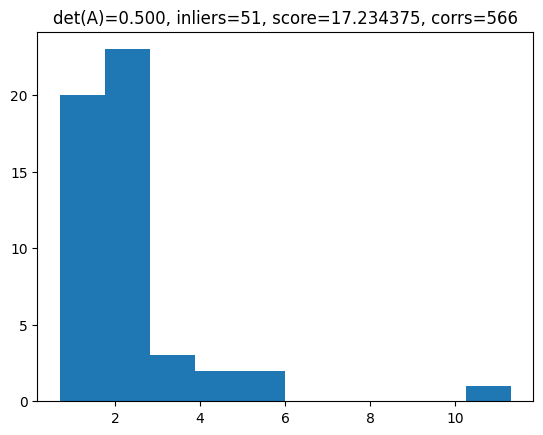

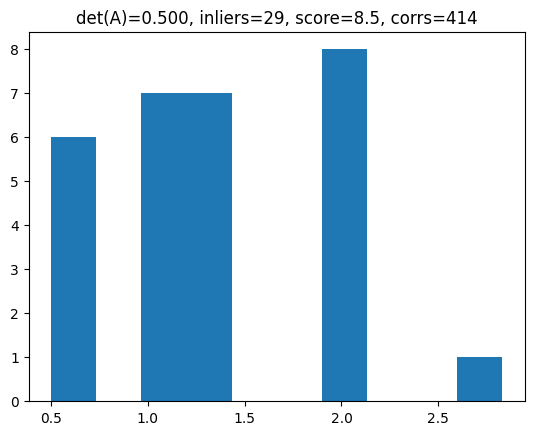

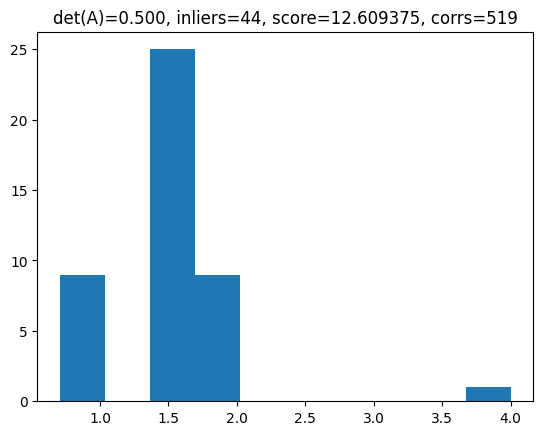

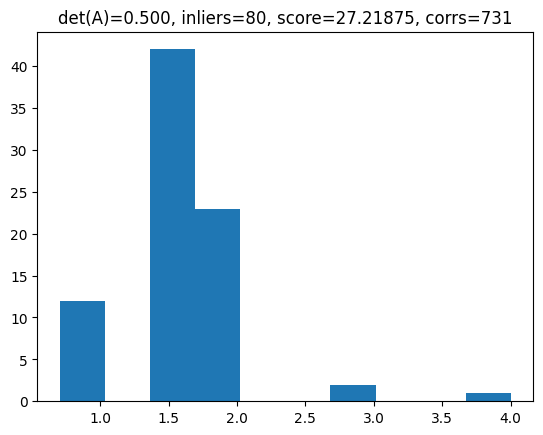

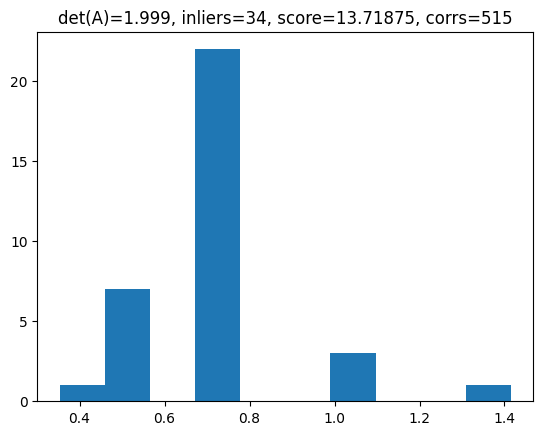

In [13]:
qi = 0

for dbi in [324, 623, 736, 2293, 4960]:
    query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')
    result_img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][dbi]}.jpg')
    qbbx = gnd['gnd'][qi]['bbx']

    # Query data
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')

    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]

    # Database data
    dbl = np.searchsorted(desc['imids'], dbi, 'left')
    dbr = np.searchsorted(desc['imids'], dbi, 'right')

    db_vecs = desc['vecs'][dbl:dbr]
    db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
    db_coordx = desc['coordx'][dbl:dbr]
    db_coordy = desc['coordy'][dbl:dbr]
    db_scales = desc['scales'][dbl:dbr]
    db_residuals = db_residual_packs[dbl:dbr]

    ########################
    # SPATIAL VERIFICATION #

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    scores = (verifications * _similarities[np.newaxis]).sum(axis=1)
    best_index = scores.argmax()

    A = hypotheses[best_index]
    score = scores[best_index]
    mask = verifications[best_index]
    origin = best_index

    # Final output
    det = np.linalg.det(A)

    plt.hist(scales1[mask] / (det * scales2[mask]))
    plt.title(f'det(A)={det:.3f}, inliers={mask.sum()}, score={score}, corrs={corrs.shape[0]}')
    plt.show()

---

In [7]:
def verify_single_model(errors, scale_ratios, corrs, inlier_threshold=32):
    n = corrs.shape[0]
    mask = np.zeros([n], dtype=bool)
    taken = set()

    i = 0
    actual_y, best_index = None, None
    best_error = None
    while i < n:
        actual_y = corrs[i, 1]
        
        best_error = np.inf
        best_index = -1
        while i < n and actual_y == corrs[i, 1]:
            if errors[i] < best_error and (0.5 <= scale_ratios[i] <= 2.0) and corrs[i, 0] not in taken:
                best_error = errors[i]
                best_index = i
            i += 1
        
        if best_error <= inlier_threshold:
            mask[best_index] = True
            taken.add(corrs[best_index, 0])
    
    return mask


def verify_models(errors, scale_ratios, corrs, inlier_threshold=32):
    assert errors.shape == scale_ratios.shape
    assert errors.shape[1] == corrs.shape[0]
    
    out = np.zeros_like(errors, dtype=bool)
    for i in range(errors.shape[0]):
        out[i] = verify_single_model(
            errors=errors[i],
            scale_ratios=scale_ratios[i],
            corrs=corrs,
            inlier_threshold=inlier_threshold,
        )
     
    return out
    #return np.apply_along_axis(
    #    partial(verify_single_model, scale_ratios=scale_ratios, corrs=corrs, inlier_threshold=inlier_threshold),
    #    axis=1,
    #    arr=errors,
    #)

In [8]:
metadata, images, ranks, _scores = asmk_dataset.query_ivf(desc['qvecs'], desc['qimids'])
compute_map_and_print(DATASET, ranks.T, gnd['gnd'])

>> roxford5k: mAP E: 94.75, M: 78.19, H: 55.51
>> roxford5k: mP@k[1, 5, 10] E: [100.    96.18  94.5 ], M: [100.    96.    92.86], H: [95.71 81.14 72.  ]


In [11]:
t0 = perf_counter()
#  =========================
MAX_SPATIAL = 100
EPS = 10e-10

ranks_copy = ranks.copy()
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])

inlier_scale_ratios = []

for qi in range(images.size):  # query index
    ql = np.searchsorted(desc['qimids'], images[qi], 'left')
    qr = np.searchsorted(desc['qimids'], images[qi], 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    dbls = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'left')
    dbrs = np.searchsorted(desc['imids'], ranks[qi, :MAX_SPATIAL], 'right')
    
    supports = np.zeros([MAX_SPATIAL])
    for dbi, (dbl, dbr) in enumerate(zip(dbls, dbrs)):
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        determinants = np.linalg.det(hypotheses)[:, np.newaxis]
        if 0 in determinants:
            print(f'There is a zero determinant in hypo generation! qi={qi}, dbi={ranks[qi, dbi]}')
        scale_ratios = np.abs(np.sqrt(determinants + EPS) * scales1 / scales2)
        verifications = verify_models(errors, scale_ratios, corrs)
        
        # Local optimization of the best model
        _original_supports = (verifications * _similarities[np.newaxis]).sum(axis=1)
        sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

        total_support = -1
        total_A = None
        total_mask = None
        
        for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
            A = hypotheses[best_hypothesis_index]
            mask = verifications[best_hypothesis_index]

            support = (mask * _similarities).sum()

            while True:
                new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
                errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
                determinants = np.abs(np.linalg.det(new_A[np.newaxis])[:, np.newaxis])
                if 0 in determinants:
                    print(f'There is a zero determinant in LO! qi={qi}, dbi={ranks[qi, dbi]}')
                scale_ratios = np.sqrt(determinants + EPS) * scales1 / scales2
                new_mask = verify_models(errors, scale_ratios, corrs)[0]
                new_support = (new_mask * _similarities).sum()

                if new_support > support:
                    support = new_support
                    A = new_A
                    mask = new_mask
                else:
                    break
            
            if support > total_support:
                total_support = support
                total_A = A
                total_mask = mask
        
        # Save the support
        supports[dbi] = total_support
        
        # If we have enough inliers, compute and save the scale ratios
        if total_mask.sum() >= 5:
            errors = compute_errors(total_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
            unit_scale_ratios = np.ones_like(errors)
            mask = verify_models(errors, unit_scale_ratios, corrs)[0]
            
            determinant = np.abs(np.linalg.det(total_A))
            if determinant == 0:
                print(f'Determinant equals to 0 even in the final part')
            scale_ratios = np.sqrt(determinant) * scales1 / scales2
            
            inlier_scale_ratios.extend(scale_ratios[mask])
            
    
    new_order = (-supports).argsort()
    ranks_copy[qi, :MAX_SPATIAL] = ranks[qi, new_order]
    
    
#  =========================
t1 = perf_counter()
t1 - t0

537.1150170839974

In [12]:
compute_map_and_print(DATASET, ranks_copy.T, gnd['gnd'])

>> roxford5k: mAP E: 87.54, M: 72.88, H: 48.3
>> roxford5k: mP@k[1, 5, 10] E: [95.59 89.93 87.4 ], M: [95.71 91.14 86.71], H: [87.14 70.86 62.14]


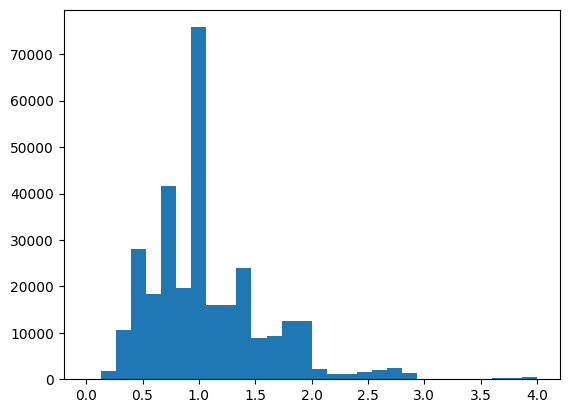

In [17]:
plt.hist(inlier_scale_ratios, range=(0, 4), bins=30)
plt.show()